# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

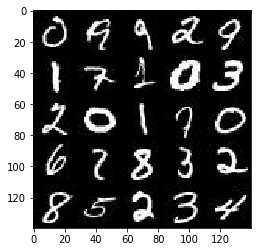

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

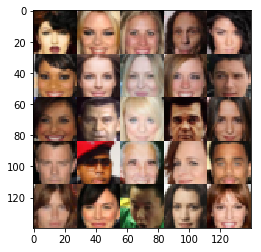

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_images')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_images, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x = tf.maximum(x, alpha * x)
        x = tf.nn.dropout(x, keep_prob)
        # 14*14*64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, alpha * x)
        x = tf.nn.dropout(x, keep_prob)
        # 7*7*128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, alpha * x)
        x = tf.nn.dropout(x, keep_prob)
        # 4*4*256
        
        x = tf.reshape(x, (-1, 4 * 4 * 256))
        
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7 * 7 * 512)

        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, alpha * x)
        x = tf.nn.dropout(x, keep_prob)
        # 7x7x512
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, alpha * x)
        x = tf.nn.dropout(x, keep_prob)
        # 14x14x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, alpha * x)
        x = tf.nn.dropout(x, keep_prob)
        # 28x28x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, alpha * x)
        x = tf.nn.dropout(x, keep_prob)
        # 28x28x128

        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=1, padding='same')

        out = tf.tanh(logits)

        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, discriminator_keep_prob=0.8, generator_keep_prob=0.5):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha, keep_prob=generator_keep_prob)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, keep_prob=discriminator_keep_prob)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, keep_prob=discriminator_keep_prob)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, keep_prob = 1.0),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data (n_images, width, height, image_channels)
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    total_images, image_width, image_height, image_channels = data_shape


    # Build network
    real_inputs, z_inputs, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    discriminator_keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    generator_keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels, alpha, discriminator_keep_prob, generator_keep_prob)

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    n_batches = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Multiply value by 2 to change value range from [-0.5, 0.5] to [-1.0, 1.0]
                images_input = np.dot(batch_images, 2)
                n_batches += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={real_inputs: images_input, z_inputs: batch_z, lr: learning_rate, discriminator_keep_prob:0.8, generator_keep_prob:0.5})
                
                # Run the optimization for the generator twice to make sure that the discriminator
                # loss does not go to zero.
                _ = sess.run(g_opt,
                             feed_dict={z_inputs: batch_z, real_inputs: images_input, lr: learning_rate, discriminator_keep_prob:0.8, generator_keep_prob:0.5})
                _ = sess.run(g_opt,
                             feed_dict={z_inputs: batch_z, real_inputs: images_input, lr: learning_rate, discriminator_keep_prob:0.8, generator_keep_prob:0.5})

                if n_batches % print_every == 0:
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: images_input, discriminator_keep_prob:1.0, generator_keep_prob:1.0})
                    train_loss_g = g_loss.eval({z_inputs: batch_z, discriminator_keep_prob:1.0, generator_keep_prob:1.0})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if n_batches % show_every == 0:
                    show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)
        print("Result for trained generator:")
        show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 0.5624
Epoch 1/2... Discriminator Loss: 6.0455... Generator Loss: 0.0062
Epoch 1/2... Discriminator Loss: 4.8392... Generator Loss: 0.0297
Epoch 1/2... Discriminator Loss: 4.6594... Generator Loss: 0.0283
Epoch 1/2... Discriminator Loss: 1.9517... Generator Loss: 0.4820
Epoch 1/2... Discriminator Loss: 2.5875... Generator Loss: 0.2698
Epoch 1/2... Discriminator Loss: 3.7631... Generator Loss: 0.1315
Epoch 1/2... Discriminator Loss: 2.8231... Generator Loss: 0.1481
Epoch 1/2... Discriminator Loss: 2.4667... Generator Loss: 0.2228
Epoch 1/2... Discriminator Loss: 1.6853... Generator Loss: 0.5942


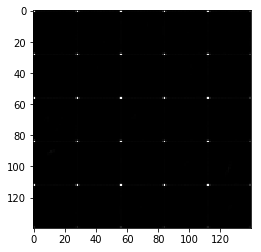

Epoch 1/2... Discriminator Loss: 3.0969... Generator Loss: 0.1008
Epoch 1/2... Discriminator Loss: 1.8770... Generator Loss: 0.3587
Epoch 1/2... Discriminator Loss: 1.6865... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 1.5293... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 2.0385... Generator Loss: 0.2976
Epoch 1/2... Discriminator Loss: 1.7730... Generator Loss: 0.4260
Epoch 1/2... Discriminator Loss: 1.8423... Generator Loss: 0.4558
Epoch 1/2... Discriminator Loss: 1.5791... Generator Loss: 0.5043
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.6870
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.8313


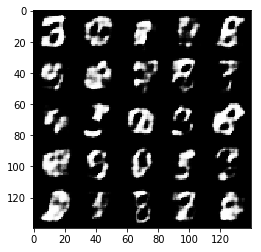

Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 1.9712... Generator Loss: 0.3313
Epoch 1/2... Discriminator Loss: 1.6336... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.5829
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 0.8172
Epoch 1/2... Discriminator Loss: 1.7137... Generator Loss: 0.4010
Epoch 1/2... Discriminator Loss: 2.4414... Generator Loss: 0.2113
Epoch 1/2... Discriminator Loss: 1.5090... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 1.2877... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 1.6154... Generator Loss: 0.5014


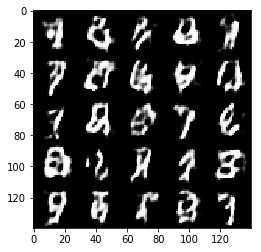

Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.5920
Epoch 1/2... Discriminator Loss: 1.7584... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 2.2441... Generator Loss: 0.2063
Epoch 1/2... Discriminator Loss: 1.9228... Generator Loss: 0.2973
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 0.7322
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 1.4891... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.5398... Generator Loss: 0.4213
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.5692... Generator Loss: 0.4644


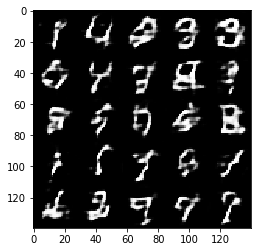

Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 1.5121... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.6745... Generator Loss: 0.4006
Epoch 1/2... Discriminator Loss: 1.6225... Generator Loss: 0.4303
Epoch 1/2... Discriminator Loss: 1.6815... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 1.6383... Generator Loss: 0.4272
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.7506
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.7583


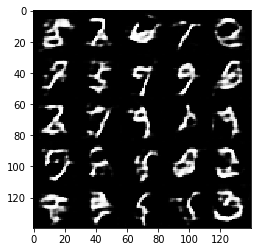

Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 0.5964
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 1.6665... Generator Loss: 0.3798
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 1.6456... Generator Loss: 0.4380


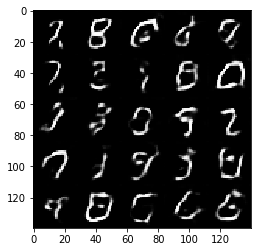

Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.5381
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 0.7674
Epoch 1/2... Discriminator Loss: 1.5759... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.5340
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 0.9378


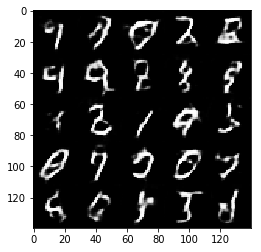

Epoch 1/2... Discriminator Loss: 1.8696... Generator Loss: 0.3440
Epoch 1/2... Discriminator Loss: 1.5307... Generator Loss: 0.4681
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.6840... Generator Loss: 0.4054
Epoch 1/2... Discriminator Loss: 1.6019... Generator Loss: 0.4248
Epoch 1/2... Discriminator Loss: 1.5673... Generator Loss: 0.4757
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.6477


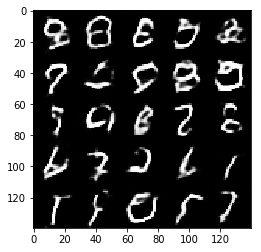

Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.5769
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.8274
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.7263... Generator Loss: 0.3960
Epoch 1/2... Discriminator Loss: 1.3111... Generator Loss: 0.6526
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 1.1358... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.6932... Generator Loss: 0.4124
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.5076
Epoch 1/2... Discriminator Loss: 1.5069... Generator Loss: 0.5414


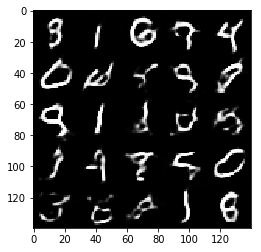

Epoch 1/2... Discriminator Loss: 1.8690... Generator Loss: 0.2911
Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.6031... Generator Loss: 0.4430
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.6714
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 1.3046... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.5474... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 1.5680... Generator Loss: 0.4409
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.6059
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.6486


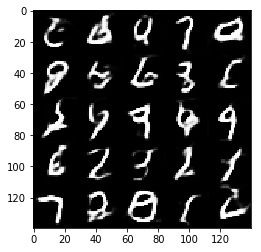

Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.5981
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.8385
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 0.6546
Epoch 1/2... Discriminator Loss: 1.5787... Generator Loss: 0.4813
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.6454
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.7959
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.5756


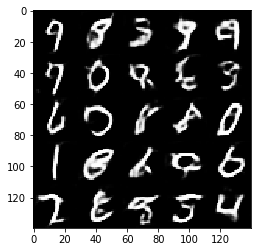

Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.8893
Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.7399
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 0.5085
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.4875


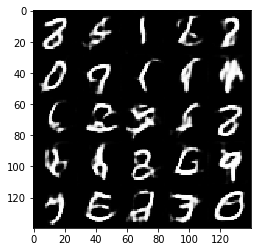

Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 1.1517... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.6678
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.4912
Epoch 1/2... Discriminator Loss: 1.3504... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 0.6086


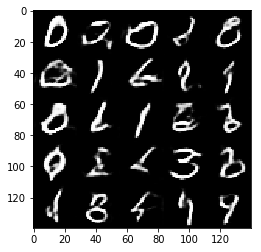

Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.6250
Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 0.4354
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.6167
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.6807
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 0.7106


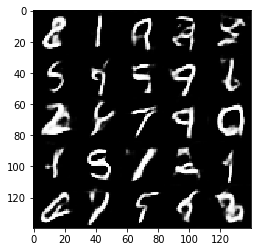

Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 0.5336
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 1.5223... Generator Loss: 0.4469
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 1.5624... Generator Loss: 0.4663
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.4305
Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 0.4478
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.6240... Generator Loss: 0.4025


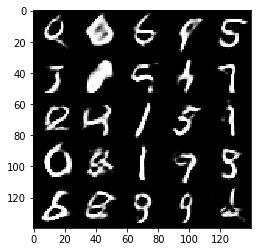

Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.5809... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.7290... Generator Loss: 0.3522
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.8718
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 0.4716
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.9439
Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 0.8493
Epoch 1/2... Discriminator Loss: 1.6706... Generator Loss: 0.4151
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.7258


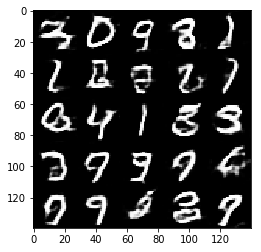

Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.7492
Epoch 1/2... Discriminator Loss: 1.2953... Generator Loss: 0.7806
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 1.0066
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.5341
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.6476
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.7136


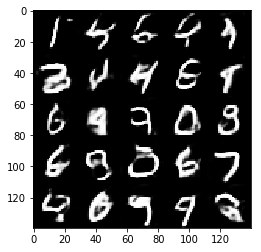

Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 0.5328
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.6935
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.6076
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.6004
Epoch 1/2... Discriminator Loss: 1.4485... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 0.6454


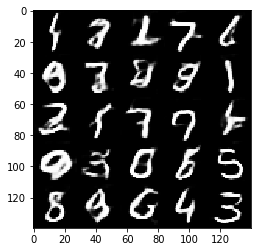

Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 0.6975
Epoch 1/2... Discriminator Loss: 1.7056... Generator Loss: 0.3854
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.4070... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.6482
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.8438
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.7241
Epoch 2/2... Discriminator Loss: 1.6625... Generator Loss: 0.4037
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.6257


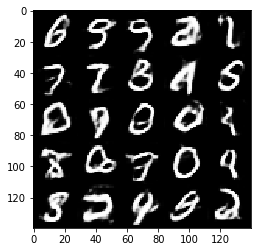

Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.6289
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.5657
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.5315
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.7436
Epoch 2/2... Discriminator Loss: 1.2786... Generator Loss: 0.6129
Epoch 2/2... Discriminator Loss: 1.5528... Generator Loss: 0.5161
Epoch 2/2... Discriminator Loss: 1.4900... Generator Loss: 0.5007
Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.7256


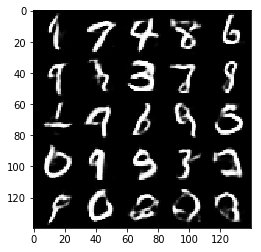

Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 1.4453... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.6699
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.5703
Epoch 2/2... Discriminator Loss: 1.2783... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 1.4680... Generator Loss: 0.4780


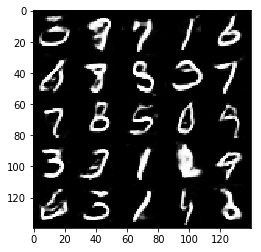

Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.5301... Generator Loss: 0.5148
Epoch 2/2... Discriminator Loss: 1.4219... Generator Loss: 0.5018
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 1.7700... Generator Loss: 0.3633
Epoch 2/2... Discriminator Loss: 1.4864... Generator Loss: 0.4941
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.5538
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 0.5623
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.4884
Epoch 2/2... Discriminator Loss: 1.6096... Generator Loss: 0.4175


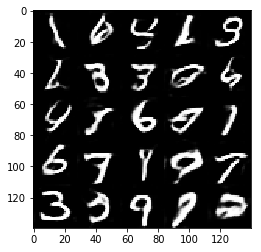

Epoch 2/2... Discriminator Loss: 1.5345... Generator Loss: 0.4714
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 1.8718... Generator Loss: 0.2746
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.4211
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 1.2783... Generator Loss: 0.7653
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.4969
Epoch 2/2... Discriminator Loss: 1.6439... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.7165


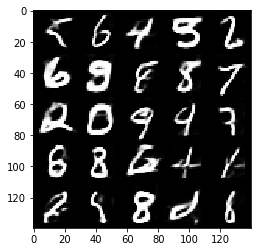

Epoch 2/2... Discriminator Loss: 1.2252... Generator Loss: 0.8001
Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 0.6288
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 0.5651
Epoch 2/2... Discriminator Loss: 1.4340... Generator Loss: 0.4862
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.5705
Epoch 2/2... Discriminator Loss: 1.4652... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.7827


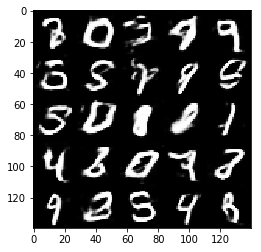

Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 1.5345... Generator Loss: 0.4453
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.5470
Epoch 2/2... Discriminator Loss: 1.5965... Generator Loss: 0.4261
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.4444... Generator Loss: 0.5182
Epoch 2/2... Discriminator Loss: 1.7494... Generator Loss: 0.3723
Epoch 2/2... Discriminator Loss: 1.3355... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.5980... Generator Loss: 0.4098
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 0.9510


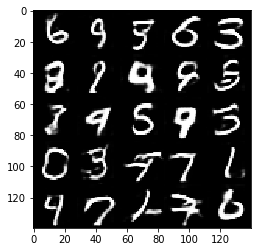

Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.8031
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 0.8205
Epoch 2/2... Discriminator Loss: 1.5947... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.6209
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.4444... Generator Loss: 0.5241
Epoch 2/2... Discriminator Loss: 1.2848... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.5448... Generator Loss: 0.4759
Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 0.7360


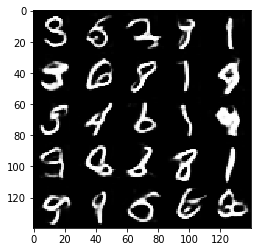

Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.5858
Epoch 2/2... Discriminator Loss: 1.4990... Generator Loss: 0.4842
Epoch 2/2... Discriminator Loss: 1.2798... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 1.6122... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 1.6702... Generator Loss: 0.4321
Epoch 2/2... Discriminator Loss: 1.4852... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 1.1134... Generator Loss: 0.7642


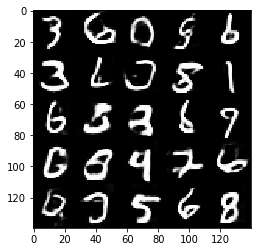

Epoch 2/2... Discriminator Loss: 1.5414... Generator Loss: 0.4865
Epoch 2/2... Discriminator Loss: 1.5843... Generator Loss: 0.4169
Epoch 2/2... Discriminator Loss: 1.4496... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.6271
Epoch 2/2... Discriminator Loss: 1.5465... Generator Loss: 0.4596
Epoch 2/2... Discriminator Loss: 1.4759... Generator Loss: 0.5611
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 0.6893
Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 0.5587
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.6725


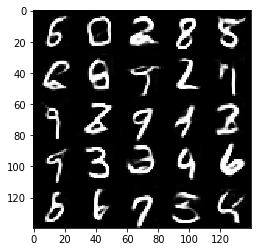

Epoch 2/2... Discriminator Loss: 1.6780... Generator Loss: 0.3567
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.5269
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.5412... Generator Loss: 0.5604
Epoch 2/2... Discriminator Loss: 1.6327... Generator Loss: 0.4111
Epoch 2/2... Discriminator Loss: 1.5045... Generator Loss: 0.5223
Epoch 2/2... Discriminator Loss: 1.5613... Generator Loss: 0.4185
Epoch 2/2... Discriminator Loss: 1.6223... Generator Loss: 0.3967
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.3974... Generator Loss: 0.5754


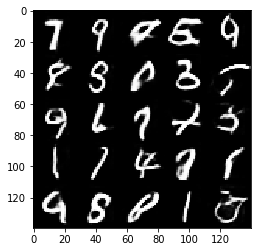

Epoch 2/2... Discriminator Loss: 1.2537... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.7964
Epoch 2/2... Discriminator Loss: 1.6362... Generator Loss: 0.4343
Epoch 2/2... Discriminator Loss: 1.4464... Generator Loss: 0.4877
Epoch 2/2... Discriminator Loss: 1.7471... Generator Loss: 0.3197
Epoch 2/2... Discriminator Loss: 1.5091... Generator Loss: 0.4541
Epoch 2/2... Discriminator Loss: 1.5161... Generator Loss: 0.4371
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.1320... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.6111


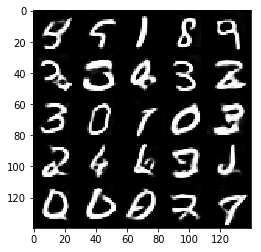

Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.5111
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 1.4469... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 1.3923... Generator Loss: 0.5122
Epoch 2/2... Discriminator Loss: 1.5356... Generator Loss: 0.4417


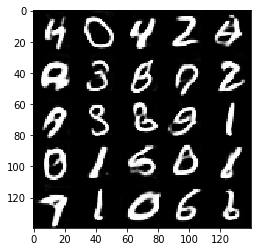

Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 0.5963
Epoch 2/2... Discriminator Loss: 1.4301... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 1.5427... Generator Loss: 0.4404
Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.5894... Generator Loss: 0.4041
Epoch 2/2... Discriminator Loss: 1.6903... Generator Loss: 0.3670
Epoch 2/2... Discriminator Loss: 1.4420... Generator Loss: 0.6194


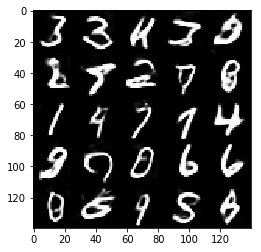

Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.4913... Generator Loss: 0.4508
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 1.4489... Generator Loss: 0.6211
Epoch 2/2... Discriminator Loss: 1.6484... Generator Loss: 0.4200
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.8517
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.5765
Epoch 2/2... Discriminator Loss: 1.4071... Generator Loss: 0.5283
Epoch 2/2... Discriminator Loss: 1.5513... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.6241


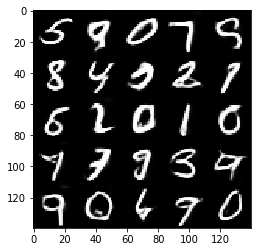

Epoch 2/2... Discriminator Loss: 1.2209... Generator Loss: 0.6774
Epoch 2/2... Discriminator Loss: 1.2017... Generator Loss: 0.8287
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 1.5788... Generator Loss: 0.4286
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.6205
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.5280
Epoch 2/2... Discriminator Loss: 1.4510... Generator Loss: 0.5207
Epoch 2/2... Discriminator Loss: 1.5613... Generator Loss: 0.4230
Epoch 2/2... Discriminator Loss: 1.4821... Generator Loss: 0.5483


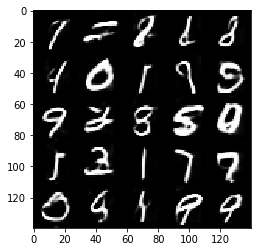

Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.5694... Generator Loss: 0.4212
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.5271
Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.6672... Generator Loss: 0.3981
Epoch 2/2... Discriminator Loss: 1.2332... Generator Loss: 0.7083
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 0.5374
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.5936
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.5402


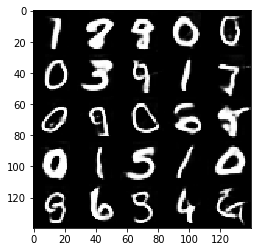

Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.5574
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.4426... Generator Loss: 0.4820
Epoch 2/2... Discriminator Loss: 1.5493... Generator Loss: 0.4457
Epoch 2/2... Discriminator Loss: 1.9262... Generator Loss: 0.2619
Epoch 2/2... Discriminator Loss: 1.5078... Generator Loss: 0.4681
Epoch 2/2... Discriminator Loss: 1.7325... Generator Loss: 0.3408
Epoch 2/2... Discriminator Loss: 1.2860... Generator Loss: 0.7915


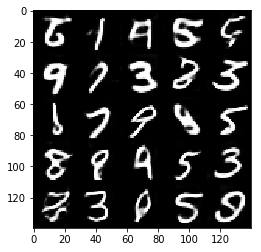

Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.5958
Epoch 2/2... Discriminator Loss: 1.3928... Generator Loss: 0.5771
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 0.5412
Epoch 2/2... Discriminator Loss: 1.5082... Generator Loss: 0.5095
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.5279
Epoch 2/2... Discriminator Loss: 1.9247... Generator Loss: 0.2651
Epoch 2/2... Discriminator Loss: 1.5166... Generator Loss: 0.4386
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.5519
Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 0.7205


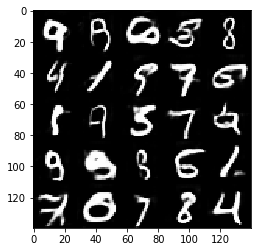

Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.5863
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.5061
Epoch 2/2... Discriminator Loss: 2.0086... Generator Loss: 0.2562
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.6238
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.8304
Result for trained generator:


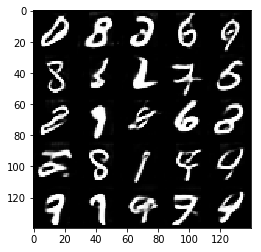

In [27]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 2.2074... Generator Loss: 0.2391
Epoch 1/1... Discriminator Loss: 3.7943... Generator Loss: 0.0780
Epoch 1/1... Discriminator Loss: 2.6934... Generator Loss: 0.2197
Epoch 1/1... Discriminator Loss: 2.6291... Generator Loss: 0.2337
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 2.9749... Generator Loss: 0.1334
Epoch 1/1... Discriminator Loss: 2.2148... Generator Loss: 0.2666
Epoch 1/1... Discriminator Loss: 3.2970... Generator Loss: 0.2391
Epoch 1/1... Discriminator Loss: 5.0956... Generator Loss: 0.0150


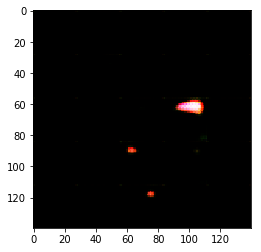

Epoch 1/1... Discriminator Loss: 4.7748... Generator Loss: 0.0386
Epoch 1/1... Discriminator Loss: 1.8302... Generator Loss: 0.4029
Epoch 1/1... Discriminator Loss: 2.9155... Generator Loss: 0.1849
Epoch 1/1... Discriminator Loss: 2.4899... Generator Loss: 0.2520
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 5.2186... Generator Loss: 0.0183
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 2.6106... Generator Loss: 0.2393
Epoch 1/1... Discriminator Loss: 6.3852... Generator Loss: 0.0051
Epoch 1/1... Discriminator Loss: 1.8946... Generator Loss: 0.5906


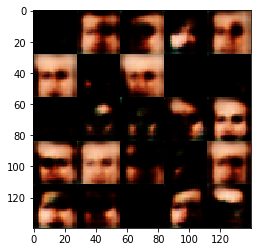

Epoch 1/1... Discriminator Loss: 2.7223... Generator Loss: 0.1777
Epoch 1/1... Discriminator Loss: 1.6299... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 2.1494... Generator Loss: 0.3387
Epoch 1/1... Discriminator Loss: 2.0965... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 2.6495... Generator Loss: 0.2240
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7036


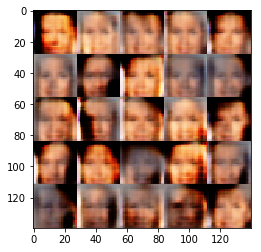

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.6368... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 2.9357... Generator Loss: 0.1464
Epoch 1/1... Discriminator Loss: 1.8405... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.9424... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 2.2445... Generator Loss: 0.2762
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 2.8611... Generator Loss: 0.1690
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7817


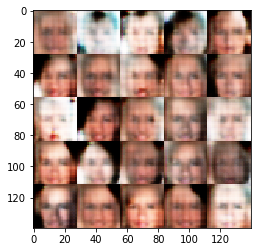

Epoch 1/1... Discriminator Loss: 1.9743... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 2.3458... Generator Loss: 0.2655
Epoch 1/1... Discriminator Loss: 1.8866... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 2.6904... Generator Loss: 0.1543
Epoch 1/1... Discriminator Loss: 2.0761... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 2.0881... Generator Loss: 0.3038
Epoch 1/1... Discriminator Loss: 2.0548... Generator Loss: 0.3016
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.8832


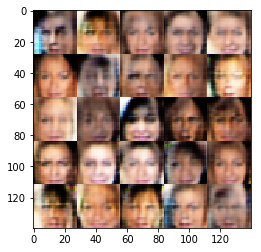

Epoch 1/1... Discriminator Loss: 2.1958... Generator Loss: 0.2918
Epoch 1/1... Discriminator Loss: 1.8961... Generator Loss: 0.3192
Epoch 1/1... Discriminator Loss: 1.9427... Generator Loss: 0.3379
Epoch 1/1... Discriminator Loss: 2.0575... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 1.8247... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 1.8821... Generator Loss: 0.3693
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.7589... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.7963... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.7386


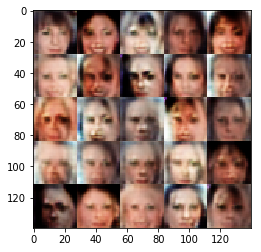

Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.8045... Generator Loss: 0.4606
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.5478
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.9878... Generator Loss: 0.3440
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.6370... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.8288... Generator Loss: 0.3624


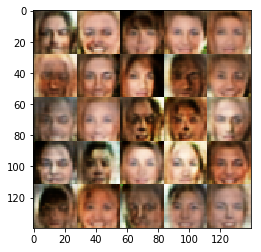

Epoch 1/1... Discriminator Loss: 1.8263... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.7715... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.7518... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.6802... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.8300... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 1.6515... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.4596


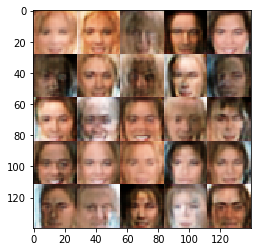

Epoch 1/1... Discriminator Loss: 1.6480... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.8323... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.8476... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.6971... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.5297


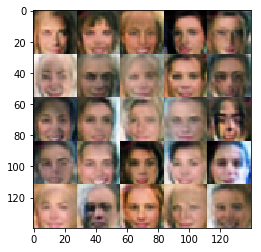

Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 0.4601
Epoch 1/1... Discriminator Loss: 1.6253... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 1.6873... Generator Loss: 0.4375
Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.4879
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.8288... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.7960... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.4369
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.4825


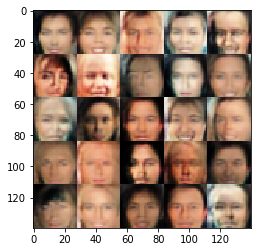

Epoch 1/1... Discriminator Loss: 1.6035... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.7564... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.6580... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.4716


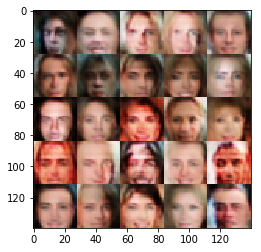

Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.6673... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.4769
Epoch 1/1... Discriminator Loss: 1.6845... Generator Loss: 0.4513


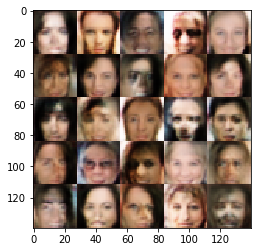

Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.6303... Generator Loss: 0.4308
Epoch 1/1... Discriminator Loss: 1.5719... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.5543... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.7046... Generator Loss: 0.4797
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.4946


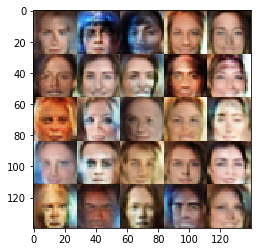

Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.5994... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.6359... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.5534


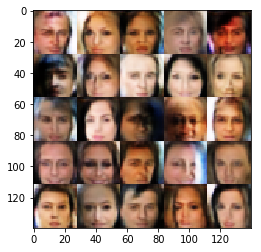

Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.5800... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.4899


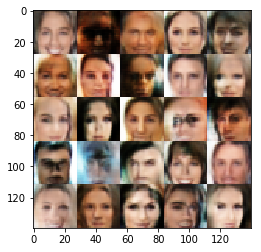

Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.5542
Result for trained generator:


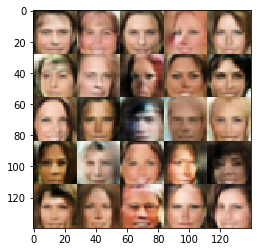

In [28]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.